### New Generation Scheme 

Here's a new generation scheme. The main idea is to assume that the proportion of left to right winged individuals is constant. 

In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import beta
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import make_scorer, log_loss, f1_score, accuracy_score

In [2]:
MAIN_PATH     = f'/mnt/storage/jcheigh/fictitious-prediction'
SRC_PATH      = f'{MAIN_PATH}/src'
IMAGE_PATH    = f'{MAIN_PATH}/images'            
DATA_PATH     = f"{MAIN_PATH}/data"
CSV_FPATH     = f'{DATA_PATH}/results.csv'

In [3]:
pop_size = 1000 # population size per timestep
lex_size = 10 # number of {right, left, neutral} words
speech_len = 15 # number of words per speech
timesteps  = 1500 # num timesteps
left_prop = .5 # expected prop of popn to be left 
alpha_p    = 3 # beta params for sampling rho
beta_p     = 3
epsilon    = 0.05 # exp prop of neutral words per speech
vocab_size = 3 * lex_size  # vocab size
num_folds  = 5 # folds per training
scoring    = 'neg_log_loss' # scoring method 

### Population Polarization Generation

For each timestep, we begin by sampling a global polarization $\rho \in [.5, 1]$. If $\rho \approx .5$ then there is very low polarization, i.e. the speeches by right/left winged individuals is very similar. If $\rho \approx 1$ then there's very high polarization. 

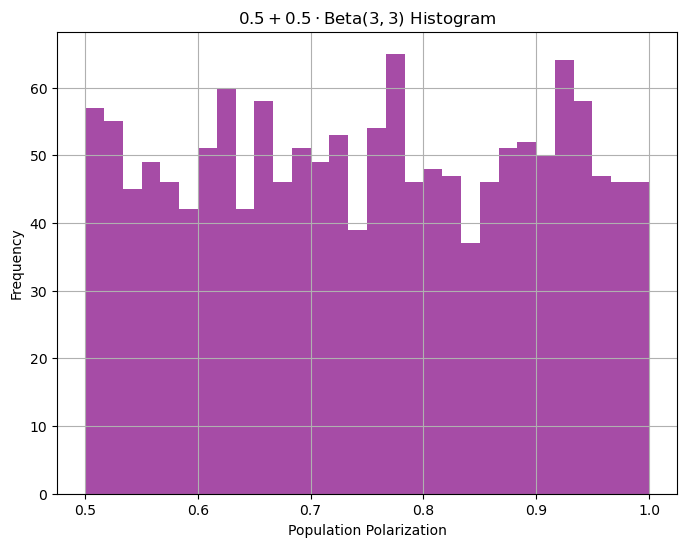

In [14]:
def get_rhos(a=alpha_p, b=beta_p, timesteps=timesteps):
    """
    generates rhos, i.e. a vector R where R[i] is the pop polarization at
    timestep i.
    """
    return np.random.uniform(0.5, 1, size=timesteps)
    #return .5 + .5 * beta.rvs(a, b, size=timesteps)

rhos = get_rhos()

plt.figure(figsize=(8, 6))
plt.hist(rhos, bins=30, color='purple', alpha=0.7)
plt.grid(True)
plt.title(r"$0.5 + 0.5 \cdot \mathrm{Beta}(3, 3)$ Histogram")
plt.xlabel("Population Polarization")
plt.ylabel("Frequency")
plt.show()

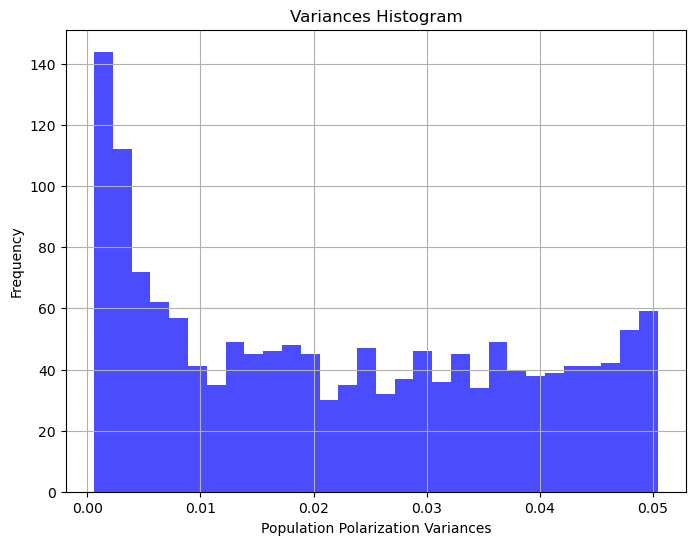

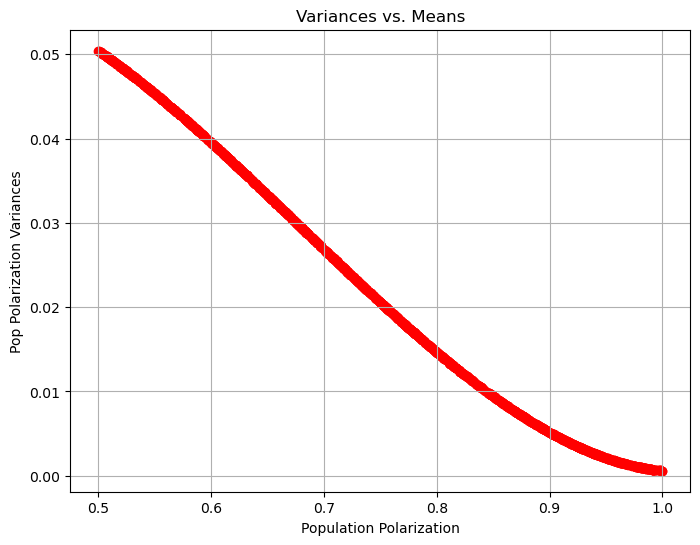

In [20]:
def get_variances(rhos):
    return (.373 * (rhos ** 3) - .76 * (rhos ** 2) + .3876 * rhos)

sigmas = get_variances(rhos)

plt.figure(figsize=(8, 6))
plt.hist(sigmas, bins=30, color='blue', alpha=0.7)
plt.grid(True)
plt.title(r"Variances Histogram")
plt.xlabel("Population Polarization Variances")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(rhos, sigmas, color='r')
plt.grid(True)
plt.title(r"Variances vs. Means")
plt.xlabel("Population Polarization")
plt.ylabel("Pop Polarization Variances")
plt.show()

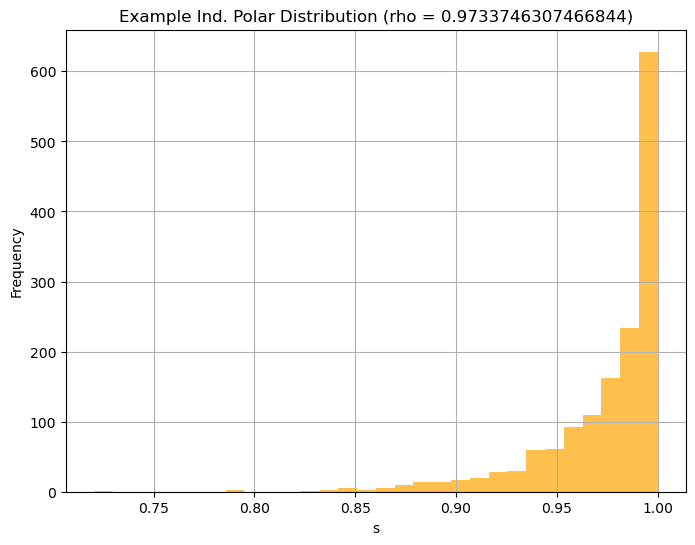

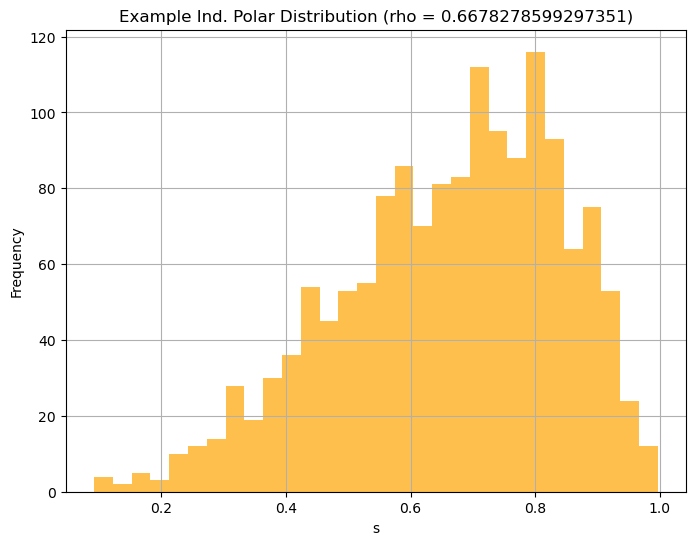

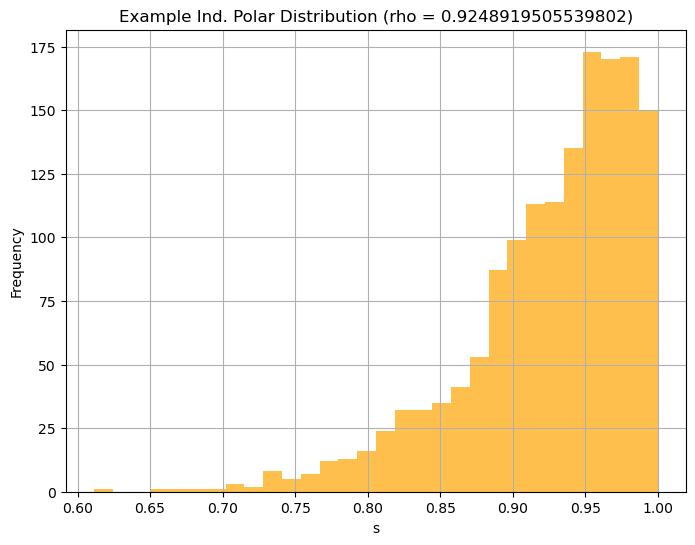

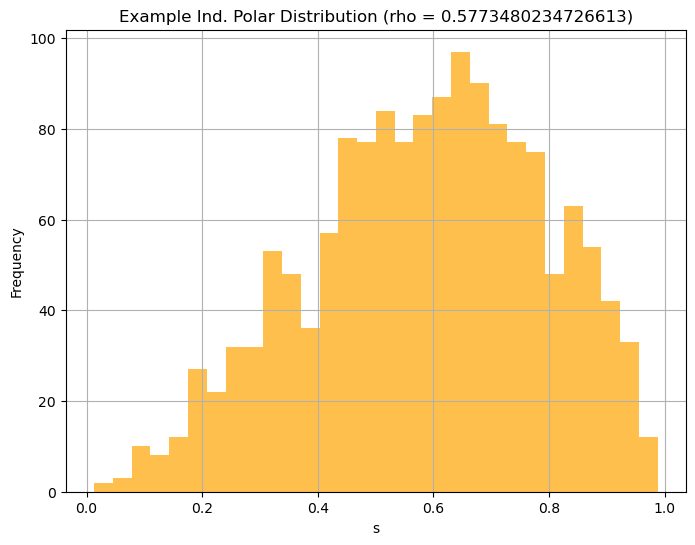

In [23]:
def get_beta_params(rhos):
    sigmas = get_variances(rhos)
    alphas = rhos * ((rhos * (1 - rhos))/sigmas - 1)
    betas  = (1 - rhos) * ((rhos * (1 - rhos))/sigmas - 1)
    return alphas, betas 

alphas, betas = get_beta_params(rhos)

for i in range(4):
    ex1 = (alphas[i], betas[i])

    plt.figure(figsize=(8, 6))
    vals = beta.rvs(ex1[0], ex1[1], size=timesteps) 
    plt.hist(vals, bins=30, color='orange', alpha=0.7)
    plt.grid(True)
    plt.title(f"Example Ind. Polar Distribution (rho = {rhos[i]})")
    plt.xlabel("s")
    plt.ylabel("Frequency")
    plt.show()
    

In [24]:
np.random.uniform(0, 1)

0.740215430561355

In [33]:
left_prop

0.5

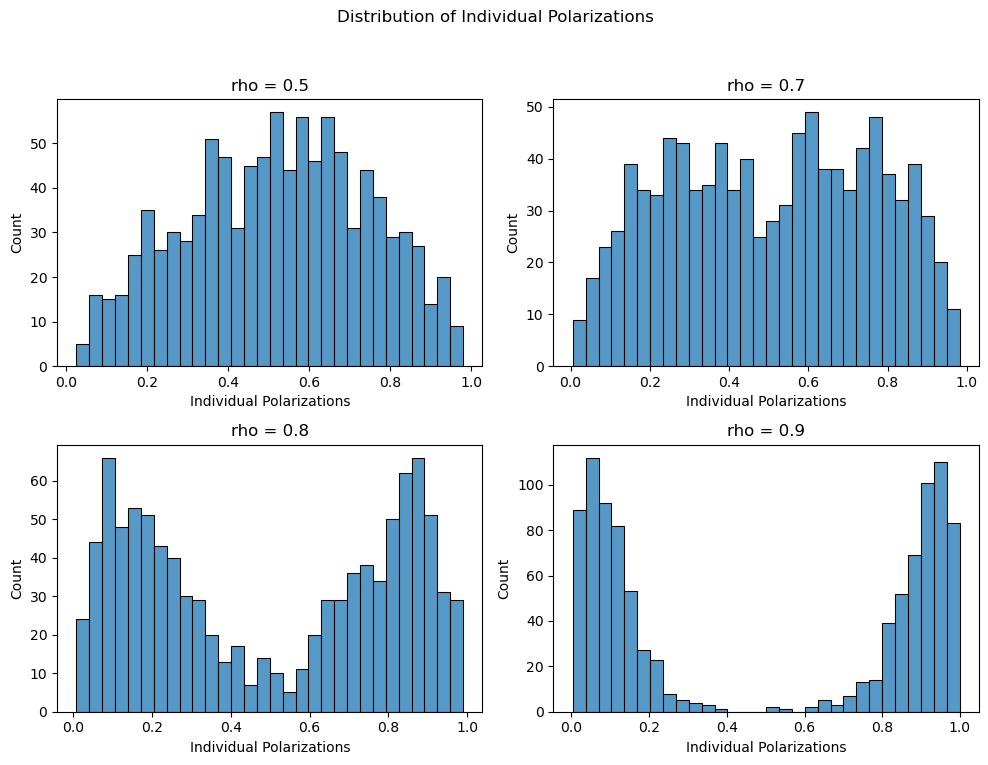

In [43]:
test_rhos   = np.array([.5, .7, .8, .9])
test_alphas, test_betas = get_beta_params(test_rhos)

data = []
for a, b in list(zip(test_alphas, test_betas)):
    n_left = int(left_prop * pop_size)
    ind_polar = np.concatenate((beta.rvs(b, a, size=n_left),beta.rvs(a, b, size=pop_size - n_left)))
    np.random.shuffle(ind_polar)
    data.append(ind_polar)

plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Individual Polarizations')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    sns.histplot(data[i], bins=30, kde=False)
    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Individual Polarizations')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

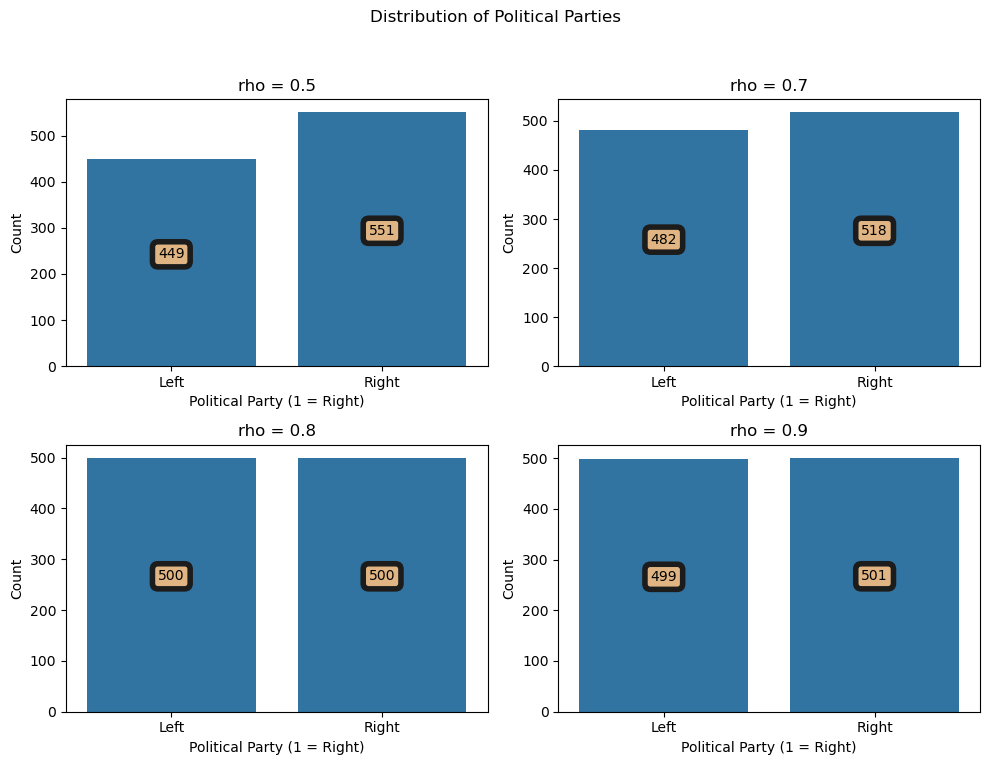

In [44]:
y_data = [(polar >= 0.5).astype(int) for polar in data]
y_data = [['Right' if y == 1 else 'Left' for y in polar] for polar in y_data]

plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Political Parties')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    p = sns.countplot(x = y_data[i], order = sorted(set(y_data[i])))

    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 10, color = "black", 
                bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                        "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})

    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Political Party (1 = Right)')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

In [45]:
polar_map = {}
for i, (a,b) in enumerate(list(zip(test_alphas, test_betas))):
    test_polars = beta.rvs(a, b, size=4)
    rho = test_rhos[i]
    polar_map[rho] = test_polars
    print(f'rho = {test_rhos[i]} -> polars = {[round(p, 2) for p in test_polars]}')

rho = 0.5 -> polars = [0.07, 0.25, 0.46, 0.67]
rho = 0.7 -> polars = [0.36, 0.73, 0.72, 0.66]
rho = 0.8 -> polars = [0.83, 0.87, 0.9, 0.95]
rho = 0.9 -> polars = [0.94, 0.98, 0.96, 0.99]


In [48]:
def get_phi(rho, u, eps=epsilon, L=lex_size):
    left_prob    = (u * (1 - rho) + (1 - u) * rho) / L
    right_prob   = (u * rho + (1 - rho) * (1 - u)) / L

    left_prob = (1 - eps) * left_prob
    right_prob = (1- eps) * right_prob
    neutral_prob = (eps / L)
    phi = [left_prob] * L + [right_prob] * L + [neutral_prob] * L
    return phi

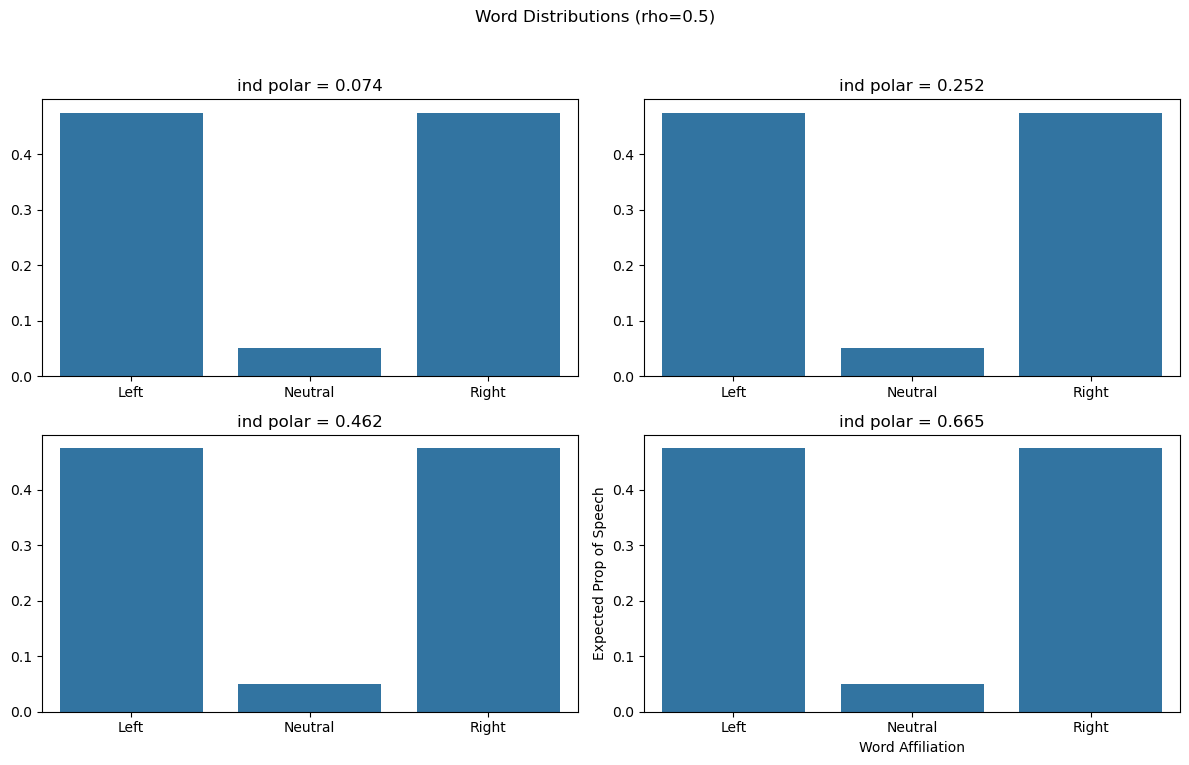

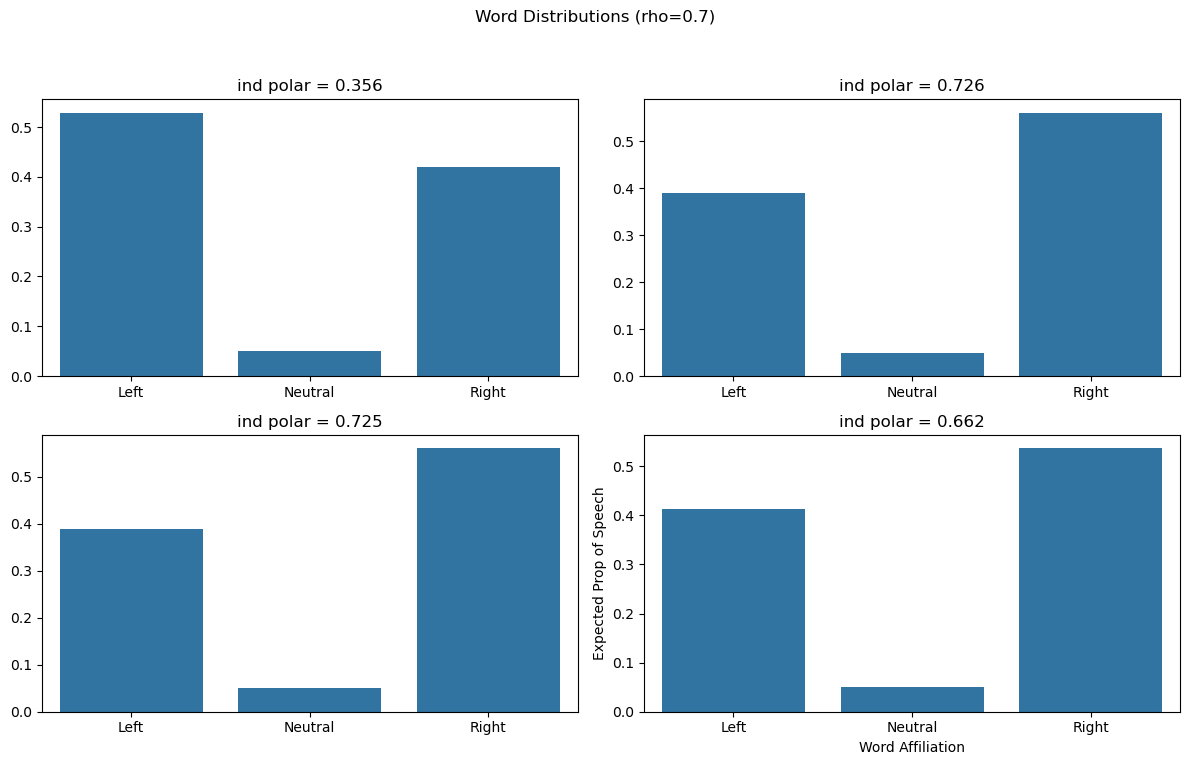

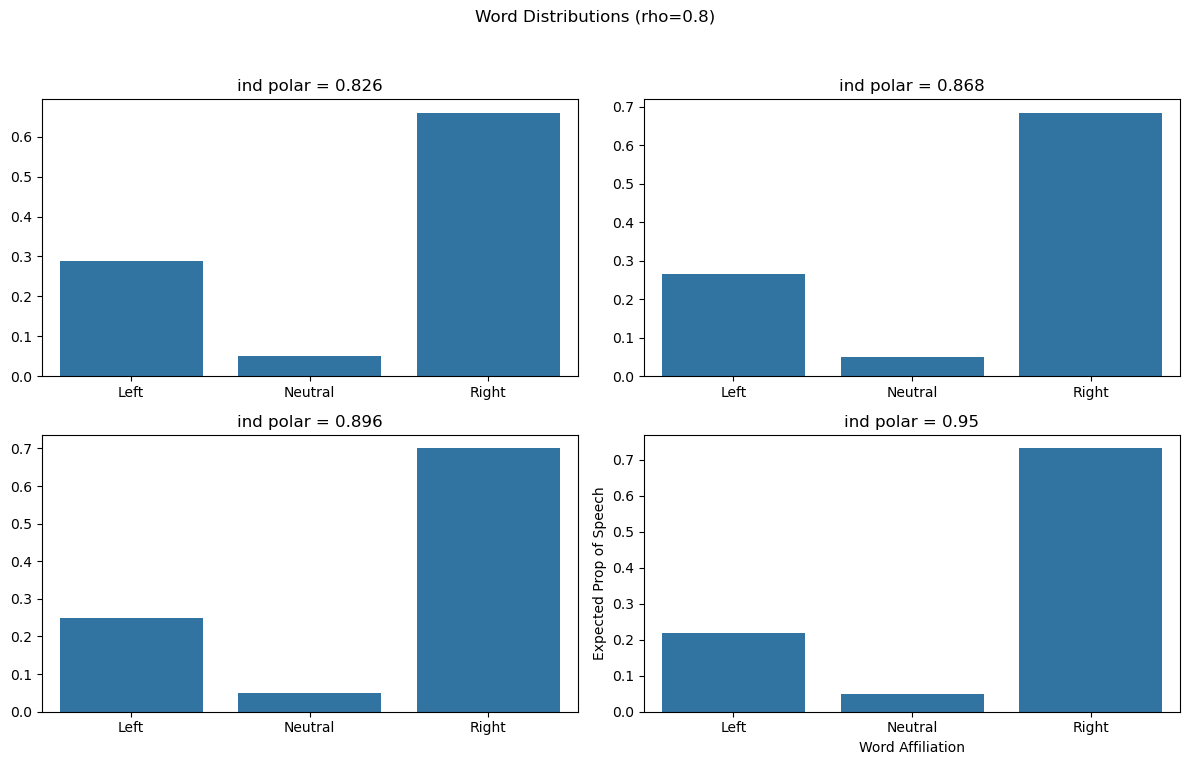

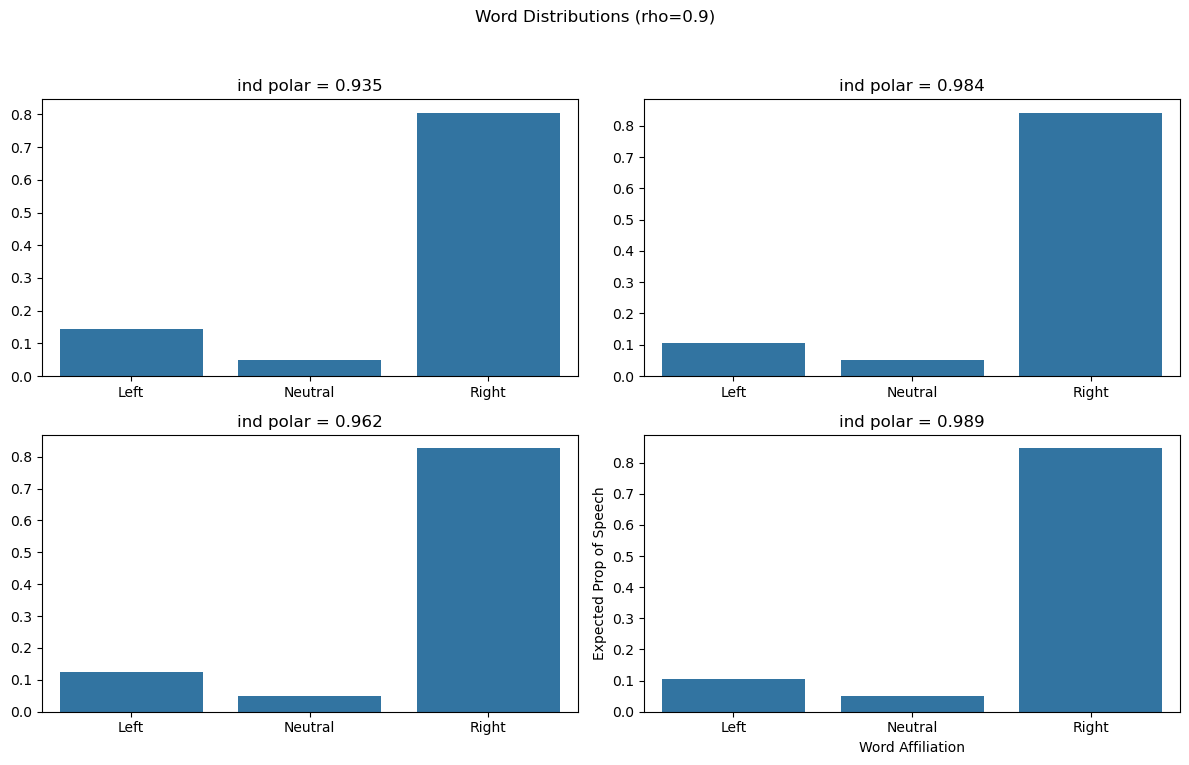

In [49]:
for rho, us in polar_map.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
    fig.suptitle(f"Word Distributions (rho={rho})")

    for i, u in enumerate(us):
        data = get_phi(rho, u)
        count_data = {
            'Left'   : lex_size * data[0],
            'Neutral': lex_size * data[-1],
            'Right'  : lex_size * data[lex_size]
        }
        categories = list(count_data.keys())
        counts = list(count_data.values())
        ax = plt.subplot(2, 2, i+1) 
        sns.barplot(x=categories, y=counts, ax=ax)
        ax.set_title(f'ind polar = {round(u, 3)}')

    plt.xlabel("Word Affiliation") 
    plt.ylabel("Expected Prop of Speech") 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [50]:
def generate():
    # Assuming get_rhos and get_beta_params are defined elsewhere and work vectorized
    rhos = get_rhos(timesteps=timesteps)
    alphas, betas = get_beta_params(rhos)
    
    n_left = int(left_prop * pop_size)
    n_right = pop_size - n_left
    
    # Vectorized beta distribution sampling
    a, b = np.broadcast_arrays(alphas[:, None], betas[:, None])
    ind_polar = np.concatenate((beta.rvs(b[:, :n_left], a[:, :n_left], size=(timesteps, n_left)),
                                beta.rvs(a[:, n_right:], b[:, n_right:], size=(timesteps, pop_size - n_left))), axis=1)
    
    np.random.shuffle(ind_polar.T)  # Shuffle across the second axis (individuals)
    
    # Calculate probabilities vectorized
    u = ind_polar[..., None]  # Add an axis for lex_size
    rho = rhos[..., None]  # Adjust dimensions for broadcasting
    
    left_prob = (u * (1 - rho) + (1 - u) * rho) / lex_size
    right_prob = (u * rho + (1 - rho) * (1 - u)) / lex_size
    left_prob *= (1 - epsilon)
    right_prob *= (1 - epsilon)
    neutral_prob = np.full_like(left_prob, epsilon / lex_size)
    
    # Concatenate probabilities to form phi
    phi = np.concatenate([left_prob, right_prob, neutral_prob], axis=-1)
    
    # Vectorized multinomial sampling
    X = np.random.multinomial(speech_len, phi.reshape(-1, phi.shape[-1])).reshape(timesteps, pop_size, 3*lex_size)
    
    # Compute y_data based on ind_polar
    y_data = (ind_polar >= 0.5).astype(int)

    return X, y_data, rhos

In [52]:
data, rhos = generate()
X, y = data[0]

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.beta` documentation for details.